In [1]:
import sklearn
print(sklearn.__version__)
import torch
print(torch.__version__)
import argparse
print(argparse.__version__)
import numpy
print(numpy.__version__)
import cv2
print(cv2.__version__)
import torchvision
print(torchvision.__version__)
import skimage
print(skimage.__version__)
import scipy
print(scipy.__version__)

0.22.2.post1
1.7.0+cu101
1.1
1.19.4
4.1.2
0.8.1+cu101
0.16.2
1.4.1


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
!cp '/gdrive/My Drive/software/Unet_Pytorch/experiment_scripts/unet.py' unet.py

In [4]:
#!pip install unet

In [5]:
import sys
sys.path.append('/content')
from unet import UNet #code borrowed from https://github.com/jvanvugt/pytorch-unet

In [6]:
%cd /gdrive/My\ Drive/software/Unet_Pytorch/Data/sardines/experiment_final2

/gdrive/My Drive/software/Unet_Pytorch/Data/sardines/experiment_final2


In [7]:
!pip install tensorboardX==1.9

     |████████████████████████████████| 194kB 5.5MB/s 


In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Oct 13 08:33:05 2020

@author: vicenc
"""


import random, sys
import cv2
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.ndimage
import skimage
import time

import tables
from skimage import io, morphology
from sklearn.metrics import confusion_matrix
from tensorboardX import SummaryWriter

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from unet import UNet

import PIL

In [9]:
# Parameters

# ---dataset

base_dir = '/gdrive/My Drive/software/Unet_Pytorch/Data/'
dataname='sardines'
experiment = 'experiment_final2'


# ---training

# --- training params
batch_size=4
num_epochs = 50
edge_weight = 1.1 #edges tend to be the most poorly segmented given how little area they occupy in the training set
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch



# ---visualisation
batch_size=1 #nicer to have a single batch so that we can iterately view the output, while not consuming too much 

#--- gpu identifier
gpuid=0



In [10]:
# Check GPU availability

if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(gpuid))
    torch.cuda.set_device(gpuid)
    device = torch.device(f'cuda:{gpuid}')
else:
    device = torch.device(f'cpu')

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [11]:
# Load the model, note that the paramters are coming from the checkpoint, since the architecture of the model needs to exactly match the weights saved

checkpoint = torch.load(f"{dataname}_unet_best_model.pth")

In [12]:
model = UNet(n_classes=checkpoint["n_classes"], in_channels=checkpoint["in_channels"], padding=checkpoint["padding"],depth=checkpoint["depth"],
             wf=checkpoint["wf"], up_mode=checkpoint["up_mode"], batch_norm=checkpoint["batch_norm"]).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")
model.load_state_dict(checkpoint["model_dict"])


total params: 	31043586


<All keys matched successfully>

In [13]:
model.load_state_dict(checkpoint["model_dict"])

<All keys matched successfully>

In [14]:
# Define our dataset class which will be used by the dataloader

class Dataset(object):
    def __init__(self, fname ,img_transform=None, mask_transform = None, edge_weight= False):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname
        self.edge_weight = edge_weight
        
        self.img_transform=img_transform
        self.mask_transform = mask_transform
        
        self.tables=tables.open_file(self.fname)
        self.numpixels=self.tables.root.numpixels[:]
        self.nitems=self.tables.root.img.shape[0]
        self.tables.close()
        
        self.img = None
        self.mask = None
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here
        if(self.img is None): #open in thread
            self.tables=tables.open_file(self.fname)
            self.img=self.tables.root.img
            self.mask=self.tables.root.mask
       
        #get the requested image and mask from the pytable
        img = self.img[index,:,:,:]
        mask = self.mask[index,:,:]
        
        #the original Unet paper assignes increased weights to the edges of the annotated objects
        #their method is more sophistocated, but this one is faster, we simply dilate the mask and 
        #highlight all the pixels which were "added"
        if(self.edge_weight):
            weight = scipy.ndimage.morphology.binary_dilation(mask==1, iterations =2) & ~mask
        else: #otherwise the edge weight is all ones and thus has no affect
            weight = np.ones(mask.shape,dtype=mask.dtype)
        
        mask = mask[:,:,None].repeat(3,axis=2) #in order to use the transformations given by torchvision
        weight = weight[:,:,None].repeat(3,axis=2) #inputs need to be 3D, so here we convert from 1d to 3d by repetition
        
        img_new = img
        mask_new = mask
        weight_new = weight
        
        seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the transofrmations
        if self.img_transform is not None:
            random.seed(seed) # apply this seed to img transforms
            img_new = self.img_transform(img)

        if self.mask_transform is not None:
            random.seed(seed)
            mask_new = self.mask_transform(mask)
            mask_new = np.asarray(mask_new)[:,:,0].squeeze()
            
            random.seed(seed)
            weight_new = self.mask_transform(weight)
            weight_new = np.asarray(weight_new)[:,:,0].squeeze()

        return img_new, mask_new, weight_new
    def __len__(self):
        return self.nitems

#####################################################################################################################################
# Note that since we need the transformations to be reproducible for both masks and images we do the spatial transformations first, and afterwards do any color augmentations

# In the case of using this for output generation, we want to use the original images since they will give a better sense of the exepected 
#output when used on the rest of the dataset, as a result, we disable all unnecessary augmentation.
#the only component that remains here is the randomcrop, to ensure that regardless of the size of the image
#in the database, we extract an appropriately sized patch
        
img_transform = transforms.Compose([
     transforms.ToPILImage(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    #transforms.RandomResizedCrop(size=patch_size),
    #transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=.5),
    #transforms.RandomGrayscale(),
    transforms.ToTensor()
    ])


mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    #transforms.RandomResizedCrop(size=patch_size,interpolation=PIL.Image.NEAREST),
    #transforms.RandomRotation(180),
    ])

phases=["val"]
dataset={}
dataLoader={}
for phase in phases:
    
    dataset[phase]=Dataset(f"./{dataname}_{phase}.pytable", img_transform=img_transform , mask_transform = mask_transform ,edge_weight=edge_weight)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0, pin_memory=True) #,pin_memory=True)

#####################################################################################################################################
# matplotlib inline

#set the model to evaluation mode, since we're only generating output and not doing any back propogation
model.eval()

from skimage import color


"""
for ii , (X, y, y_weight) in enumerate(dataLoader["val"]):
    X = X.to(device)  # [NBATCH, 3, H, W]
    y = y.type('torch.LongTensor').to(device)  # [NBATCH, H, W] with class indices (0, 1)

    output = model(X)  # [NBATCH, 2, H, W]

    output=output.detach().squeeze().cpu().numpy() #get output and pull it to CPU
    output=np.moveaxis(output,0,-1)  #reshape moving last dimension
    
    fig, ax = plt.subplots(1,4, figsize=(10,4))  # 1 row, 2 columns

    ax[0].imshow(output[:,:,1])
    ax[1].imshow(np.argmax(output,axis=2))
    ax[2].imshow(y.detach().squeeze().cpu().numpy())
    ax[3].imshow(np.moveaxis(X.detach().squeeze().cpu().numpy(),0,-1))
"""


'\nfor ii , (X, y, y_weight) in enumerate(dataLoader["val"]):\n    X = X.to(device)  # [NBATCH, 3, H, W]\n    y = y.type(\'torch.LongTensor\').to(device)  # [NBATCH, H, W] with class indices (0, 1)\n\n    output = model(X)  # [NBATCH, 2, H, W]\n\n    output=output.detach().squeeze().cpu().numpy() #get output and pull it to CPU\n    output=np.moveaxis(output,0,-1)  #reshape moving last dimension\n    \n    fig, ax = plt.subplots(1,4, figsize=(10,4))  # 1 row, 2 columns\n\n    ax[0].imshow(output[:,:,1])\n    ax[1].imshow(np.argmax(output,axis=2))\n    ax[2].imshow(y.detach().squeeze().cpu().numpy())\n    ax[3].imshow(np.moveaxis(X.detach().squeeze().cpu().numpy(),0,-1))\n'

In [15]:
#creem carpeta per guardar els resultats
path_results="/gdrive/My Drive/software/Unet_Pytorch/Data/"+dataname+"/"+experiment+"/results"
os.mkdir(path_results)

FileExistsError: ignored

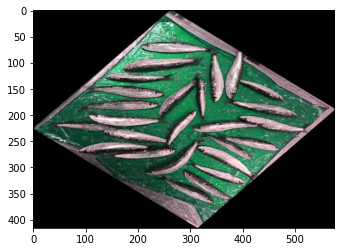

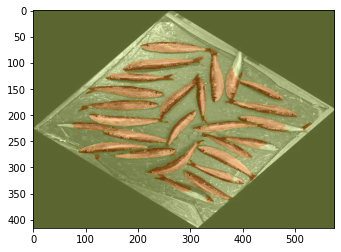

In [ ]:
#set the model to evaluation mode, since we're only generating output and not doing any back propogation
model.eval()

from skimage import color

for ii , (X, y, y_weight) in enumerate(dataLoader["val"]):
    X = X.to(device)  # [NBATCH, 3, H, W]
    y = y.type('torch.LongTensor').to(device)  # [NBatch, H, W] with class indices (0, 1)

    output = model(X)  # [NBatch, 2, H, W]

    output=output.detach().squeeze().cpu().numpy() #get output and pull it to CPU
    output=np.moveaxis(output,0,-1)  #reshape moving last dimension
    #fig, ax = plt.subplots(1,4, figsize=(20,20))
    #plt.imshow(output[:,:,1]>0.5)
    #plt.imshow(np.argmax(output,axis=2))
    #plt.show()
    #plt.imshow(y.detach().squeeze().cpu().numpy())
    #plt.show()
    plt.imshow(np.moveaxis(X.detach().squeeze().cpu().numpy(),0,-1))
    plt.show()
    
    im_2 = color.rgb2gray(np.moveaxis(X.detach().squeeze().cpu().numpy(),0,-1))
    plt.imshow(im_2,cmap='gray')
    
#    plt.imshow(np.moveaxis(X.detach().squeeze().cpu().numpy(),0,-1))
    
    #plt.imshow(output[:,:,1],cmap = 'Wistia', alpha = 0.4)
    #plt.imshow(np.argmax(output,axis=2), cmap = 'Wistia', alpha = 0.4)
    treshold=0.8
    #image=np.where(output[:,:,1]>treshold,1,0), cmap = 'Wistia', alpha = 0.4
    plt.imshow(np.where(output[:,:,1]>treshold,1,0), cmap = 'Wistia', alpha = 0.4)
    
    
    # save results
    fig1 = plt.gcf()
    plt.show()
    #plt.imsave(str(ii),(np.where(output[:,:,1]>treshold,1,0), cmap = 'Wistia', alpha = 0.4))
    fig1.savefig('results/'+str(ii),dpi=500)
    input("Press Enter to continue...")